# THE PANAMA PAPERS

## Link to data story
The data story can be found at [this link](https://ada-akbar.github.io/2018/12/13/panama-papers.html)

In [1]:
# Import the necessary packages to perform the data analysis

# packages to process and visualize the data
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
from scipy import stats

# import othe useful packages
import os
from geopy.geocoders import Nominatim
from math import pi
import math
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.models import HoverTool, LogColorMapper, LogTicker, ColorBar
from bokeh.layouts import row as row_plot

# packages to improve visual description and analysis
from IPython.core.display import display
pd.set_option('display.max_columns', 100)

In [2]:
# Getting file names

DATA_FOLDER = './data/'

# Panama papers data
edges_csv = 'panama_papers.edges.csv'
intermediary_csv = 'panama_papers.nodes.intermediary.csv' # company or individuals
address_csv = 'panama_papers.nodes.address.csv'
officer_csv = 'panama_papers.nodes.officer.csv'
entity_csv = 'panama_papers.nodes.entity.csv' # tax haven companies
entity_csv_mod = 'panama_papers_modified.nodes.entity.csv'

The followings are the additional datasets used for the investigation taken in the [World Bank Dataset](https://data.worldbank.org):

- `API_SI.POV.GINI_DS2_en_csv_v2_10224868.csv`, is the GINI coefficient per country

- `API_NY.GDP.MKTP.CD_DS2_en_csv_v2_10224782.csv`, is the GDP per country

- `API_NY.GDP.PCAP.CD_DS2_en_csv_v2_10224851.csv`, is the GDP per capita per country

- `API_IC.GOV.DURS.ZS_DS2_en_csv_v2_10230883.csv`, is the time spent by business in government regulation per country

- `API_GC.TAX.YPKG.RV.ZS_DS2_en_csv_v2_10227627.csv`, is the tax rate on income, profits and capital gains per country

- `API_IC.REG.DURS_DS2_en_csv_v2_10225592.csv`, days to open a business

Every dataset is divided in n rows as many countries in the world and p columns for a range p of years usually going from the sixties to 2018. Hence each column represent the indicator per year. Not all countries have an indicator each year. Examples are given in the notebook.

In [3]:
#World Bank dataset
GINI_coeff = 'API_SI.POV.GINI_DS2_en_csv_v2_10224868.csv'
GDP_tot = 'API_NY.GDP.MKTP.CD_DS2_en_csv_v2_10224782.csv'
GDP_cap = 'API_NY.GDP.PCAP.CD_DS2_en_csv_v2_10224851.csv'
time_spent_by_bus = 'API_IC.GOV.DURS.ZS_DS2_en_csv_v2_10230883.csv'
tax_rate = 'API_GC.TAX.YPKG.RV.ZS_DS2_en_csv_v2_10227627.csv'
days_open_business='API_IC.REG.DURS_DS2_en_csv_v2_10225592.csv'

The followings are the additional datasets used for the investigation taken in the [Organisation for Economic Co-operation and Development (OECD) database](https://data.oecd.org/):

- `corp_tax_rate.csv`, is the corporate tax rate per country from 2000

- `business_country.csv`, in the number of businesses per country

In this case only the corporate tax rate has different columns, with different data for every year.

In [4]:
#OECD dataset
corp_tax_rate = 'corp_tax_rate.csv'
business_country = 'business_country.csv'

In [5]:
# Importing the Panama Papers data into DataFrames
df_edges_raw = pd.read_csv(DATA_FOLDER + edges_csv,low_memory=False)
df_address_raw = pd.read_csv(DATA_FOLDER + address_csv,low_memory=False)
df_entity_raw = pd.read_csv(DATA_FOLDER + entity_csv,low_memory=False)
df_intermediary_raw = pd.read_csv(DATA_FOLDER + intermediary_csv,low_memory=False)
df_officier_raw = pd.read_csv(DATA_FOLDER + officer_csv,low_memory=False)
df_entity_mod_raw = pd.read_csv(DATA_FOLDER + entity_csv_mod,low_memory=False,encoding = "ISO-8859-1")

In [6]:
#Importing World Bank Data
df_GDP_tot_raw=pd.read_csv(DATA_FOLDER + GDP_tot,skiprows=4)
df_GDP_cap_raw=pd.read_csv(DATA_FOLDER + GDP_cap,skiprows=4)
df_tax_rate=pd.read_csv(DATA_FOLDER+tax_rate, skiprows=4)
df_ease_business=pd.read_csv(DATA_FOLDER+days_open_business,skiprows=4)
df_gini=pd.read_csv(DATA_FOLDER+GINI_coeff, skiprows=4)
df_time_regulation=pd.read_csv(DATA_FOLDER+days_open_business, skiprows=4)

In [7]:
#Importing OECD Data
corp_tax_rate_df = pd.read_csv(DATA_FOLDER + corp_tax_rate)
business_country_df = pd.read_csv(DATA_FOLDER + business_country)

# Preliminary data wrangling

## Handling data size

First we will answer the question of whether we can handle the data in size.

In [8]:
# Printing shapes of each DataFrame to see if any are too large

print("Edges shape: ", df_edges_raw.shape)
print("Intermediary shape: ", df_intermediary_raw.shape)
print("Address shape: ", df_address_raw.shape)
print("Officer shape: ", df_officier_raw.shape)
print("Entity shape: ", df_entity_raw.shape)

Edges shape:  (674102, 8)
Intermediary shape:  (14110, 8)
Address shape:  (93454, 8)
Officer shape:  (238402, 7)
Entity shape:  (213634, 17)


From above, we see that the DataFrame with the most number of rows is around 670,000 rows of data. In total the size of the Panama Papers dataset is around 352 MB, which is small enough for Jupyter Notebook and Pandas to handle effectively. Thus the data can definitely be handled within our approach of using purely a notebook. 

## Understanding the data

Next we understand the data. Although the dataset is downloaded within `csv` format, the data is curated to work well within a graph database (specifically Neo4j as mentioned on the Panama Papers website). Here, the `Edges` table represents the edge connections within a graph database whereas all the other tables (`Intermediary`, `Address`, etc) are nodes within the graph. For example:

In [9]:
display(df_edges_raw.head(1))

,START_ID,TYPE,END_ID,link,start_date,end_date,sourceID,valid_until
0,10000035,registered_address,14095990,registered address,NaN,NaN,Panama Papers,NaN


To interpret this row in the `Edges` table, the `START_ID` and `END_ID` represent the node ids that the edge is connected to. But the node ids can correspond to any of `Intermediary, Address, Officer, Entity`, which may prove to be difficult in SQL or Pandas merging as we will have to look up the node id in every other table. One solution would be to use Neo4j and the Cypher querying language, which can be used to easily interpret the above information. Below we can see clearly that the start node is an Entity named *CARPENTER NELSON & CO., LTD* and the end node is an Address named *EUROFIN SERVICES S.A. P.O.BOX  6003 LAUSANNE 1002, VAUD SWITZERLAND* and the relationship type is *registered address*.

<img src="ex_query1.png" height="400" width="1000">

For the purposes of our project, we may not even need to use Neo4j to answer our queries. However we have done the above analyis to identify the format of our data, which is crucial because if we do require a certain query, we understand how we can leverage different tools to achieve our goals.

## Data Cleaning

We see that `Edges` Dataframe and `Entity` Dataframe have mixed datatypes in their columns so we will inspect those more clearly. 

In [10]:
start_dates = df_edges_raw.start_date.unique()[1:]
start_dates = sorted(list(map(lambda x: int(x[-4:]), start_dates)), reverse=True)
print(start_dates[:20])
print(start_dates[-50:])

[2500, 2205, 2201, 2099, 2088, 2088, 2020, 2019, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015]
[1974, 1973, 1973, 1972, 1968, 1966, 1965, 1959, 1957, 1957, 1194, 214, 213, 213, 206, 203, 202, 201, 201, 201, 200, 200, 200, 200, 200, 200, 200, 200, 199, 199, 96, 95, 82, 15, 14, 12, 12, 12, 12, 12, 12, 12, 12, 11, 9, 9, 6, 6, 4, 3]


We first see that the start_date and end_date columns in `Edges` have dates that are nonsensical, such as years that are well before/after 2015. Upon consideration of our research questions, we decide to drop the date columns from `Edges` as well as the Note column in `Entity` (For our research question of timeline of leaked papers, we will need to use the `Entity['incorporation_date']` column).

In [11]:
edges = df_edges_raw.drop(columns=['start_date', 'end_date'])
entity = df_entity_raw.drop(columns=['note'])

Furthermore, we see that the `Entity['incorporation_date']` column have acceptable ranges below so we will convert that column from type object to date.

In [12]:
print(entity['incorporation_date'].sort_values().unique())
entity.incorporation_date = pd.to_datetime(entity.incorporation_date)

['01-APR-1975' '01-APR-1977' '01-APR-1981' ... '31-OCT-2013' '31-OCT-2014'
 nan]


## Countries' names formatting

Eventually it is important to mention that a number of countries had different spelling in the World Bank data relatively to the names given in the Panama Papers. Hence since the number of these incongruencies was lower than 15, the names were changed manually in the Panama Paper document excel. On top of that certain small countries/islands didn't have data relative to the GDP singularly and they were included by the World Bank in bigger group of countries: for example Jersey and Guernsey are included under the name 'Channel Islands' in the World Bank dataset. Hence the names were changed in the Panama Papers dataset. The new `df_entity_mod_raw` dataframe was not considered in the first analysis because no integration with other databases was performed. 

# The Panama Papers

The Panama Papers are leaked documents that detail financial and attorney–client information for offshore entities. The documents were created by, and taken from, Panamanian law firm and corporate service provider Mossack Fonseca, and were leaked in 2015 by an anonymous source.

As shown by the exploratory analysis, the entity document of the Panama Papers is very interesting: it provides a macroscopic view of how many entities per countries are involved in settling companies offshore or funds offshore. The reasons behind making an offshore company are multiple: setting a company offshore is not a crime, but it can be an indication that the business condition in the home country are not always favorable from a privacy point of view, from a bureaucratic point of view and from a tax point of view. Hence it is crucial to understand why entities decide to set their companies offshore and what is the consequence on the home country from a wealth distribution point of view. To carry out this investigation a set of questions which provide a guideline for this analysis are going to be answered:

**1)** Which are the jurisdictions in which entities found in Panama papers are registered?

**2)** What countries have the most entities register in the Panama papers?

**3)** What drives entities to go offshore and consequently how does that affect the country? 

**4)** What are the consequences of offshore companies on income inequality? 

## 1) Which are the jurisdictions in which entities found in Panama papers are registered?

Here the jurisdiction column of the entity file is considered. It represents the county where the offshore entity is register.

In [13]:
df_entity_raw['jurisdiction_description'].unique()

array(['Samoa', 'Panama', 'Nevada', 'United Kingdom', 'Singapore',
       'Ras Al Khaimah', 'Isle Of Man', 'British Anguilla', 'Seychelles',
       'Niue', 'Uruguay', 'British Virgin Islands', 'Hong Kong',
       'New Zealand', 'Bahamas', 'Cyprus', 'Malta', 'Belize', 'Jersey',
       'Wyoming', 'Costa Rica'], dtype=object)

To better represent all the country present on different graph, all the countries appearing less times than a certain number called here threshold are grouped and considered in following steps as `Others`.

In [14]:
threshold1=1000
df_entity_S1=df_entity_raw.copy()
vc=df_entity_S1.jurisdiction_description.value_counts()
tax_havens_L=list(vc[vc > threshold1].index)
tax_havens_S=list(vc[vc <= threshold1].index)
df_entity_S1.loc[~df_entity_S1.jurisdiction_description.isin(tax_havens_L), 'jurisdiction_description'] = 'Others'
df_entity_S1.jurisdiction_description.value_counts()

British Virgin Islands    113648
Panama                     48360
Bahamas                    15915
Seychelles                 15182
Niue                        9611
Samoa                       5307
British Anguilla            3253
Nevada                      1260
Others                      1098
Name: jurisdiction_description, dtype: int64

A simple histogram is plotted. Logarithmic scale on the $y-axis$ is later applied noticed an approximated exponential distribution. It could be an interesting aspect to investigate. 

Countries in Others category are:  ['Hong Kong', 'United Kingdom', 'Belize', 'Costa Rica', 'Cyprus', 'Uruguay', 'New Zealand', 'Jersey', 'Wyoming', 'Malta', 'Isle Of Man', 'Ras Al Khaimah', 'Singapore']


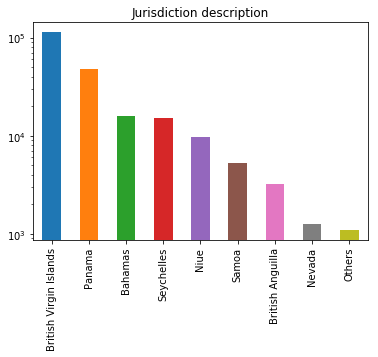

In [15]:
df_entity_S1.jurisdiction_description.value_counts().plot(kind='bar',title='Jurisdiction description', logy=True)
print('Countries in Others category are: ',tax_havens_S)

Finally, we output a world map to better visualize all the jurisdictions that have offshore entities registered. First we find the latitude and longitude of all jurisdictions with help of the `Geopy` library.

In [16]:
jurisdiction_df = pd.DataFrame(df_entity_raw.jurisdiction_description.value_counts())
jurisdiction_df.reset_index(inplace=True)
jurisdiction_df.columns = ["Area", "Count"]

# getting long, lat for all jurisdictions
geolocator = Nominatim(user_agent='ADA_AKBAR')
j_lat = []
j_long = []

for ind, row in jurisdiction_df.iterrows():
    if row['Area'] == 'British Anguilla':
        location = geolocator.geocode('Anguilla')
    else:
        location = geolocator.geocode(row['Area'])
    j_lat.append(location.latitude)
    j_long.append(location.longitude)

jurisdiction_df['Latitude'] = j_lat
jurisdiction_df['Longitude'] = j_long

Next to plot on Bokeh, we use the Mercator Projection, which converts longitude and latitude coordinates onto the Cartesian grid so that Bokeh can successfully represent them in the plot. The equation for the Mercator Projection is:

![merc](proj_jekyll/img/merc.png)

In [17]:
def merc(lat_lst, lon_lst):
    x_lst = []
    y_lst = []
    for i in range(len(lat_lst)):
        lat = lat_lst[i]
        lon = lon_lst[i]
        r_major = 6378137.000
        x = r_major * math.radians(lon)
        scale = x/lon
        y = 180.0/math.pi * math.log(math.tan(math.pi/4.0 + 
            lat * (math.pi/180.0)/2.0)) * scale
        x_lst.append(x)
        y_lst.append(y)
    return x_lst, y_lst

x_y = merc(jurisdiction_df.Latitude, jurisdiction_df.Longitude)
jurisdiction_df['x'] = x_y[0]
jurisdiction_df['y'] = x_y[1]

Finally we plot the map with hovering capabilities.

In [18]:
from bokeh.plotting import figure, show, output_file, output_notebook
from bokeh.tile_providers import CARTODBPOSITRON
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.layouts import gridplot, widgetbox
from bokeh.models.widgets import DataTable, TableColumn

def plot_map(df, title):
    source = ColumnDataSource(data=dict(
                            x=list(df['x']), 
                            y=list(df['y']),
                            count=list(df['Count']),
                            area=list(df['Area'])))

    hover = HoverTool(tooltips=[
        ("Area", "@area"),
        ("Count","@count")])

    p = figure(
        title = title,
        width = 600, 
        height= 400, 
        x_range=(-20000000, 10000000), y_range=(-100, 10000),
        x_axis_type="mercator", y_axis_type="mercator",
        tools=['pan', hover, 'wheel_zoom','save'])

    p.add_tile(CARTODBPOSITRON)

    p.circle(x = 'x',
             y = 'y', 
             size = 10,
             source=source, 
             line_color="#FF0000", 
             fill_color="#FF0000",
             fill_alpha=0.05)
    
    columns = [
        TableColumn(field="area", title="Area"),
        TableColumn(field="count", title="Count")
    ]
    
    data_table = DataTable(source=source, columns=columns, height=350, width=200)
    grid = gridplot([p, data_table], ncols=2)
    
    output_notebook()
    show(grid)

output_file("proj_jekyll/assets/jurisdictions_map.html", title="jurisdictions")
plot_map(jurisdiction_df, "Top jurisdictions by count")

Loading BokehJS ...

## 2) What countries have the most entities register in the Panama papers?

The same procedure is applied to the `country` column representing the country of origin of the offshore company. As more country are included a bigger threshold needs to be chosen in order to make the plots still readable. Same as before, the count of companies for country will be represent on an interactive map.

In [19]:
threshold2=3000
vc=df_entity_S1.countries.value_counts()
tax_evasions_L=list(vc[vc > threshold2].index)
tax_evasions_S=list(vc[vc <= threshold2].index)
df_entity_S1.loc[~df_entity_S1.countries.isin(tax_evasions_L), 'countries'] = 'Others'
df_entity_S1.countries.value_counts()

Hong Kong               37911
Switzerland             37911
Others                  36495
Panama                  15811
Jersey                  14331
Luxembourg              10840
United Kingdom           9619
Guernsey                 7327
United Arab Emirates     7269
Bahamas                  4984
Uruguay                  4906
Isle of Man              4892
Russia                   4197
Singapore                4081
Cyprus                   3613
China                    3213
Monaco                   3168
United States            3066
Name: countries, dtype: int64

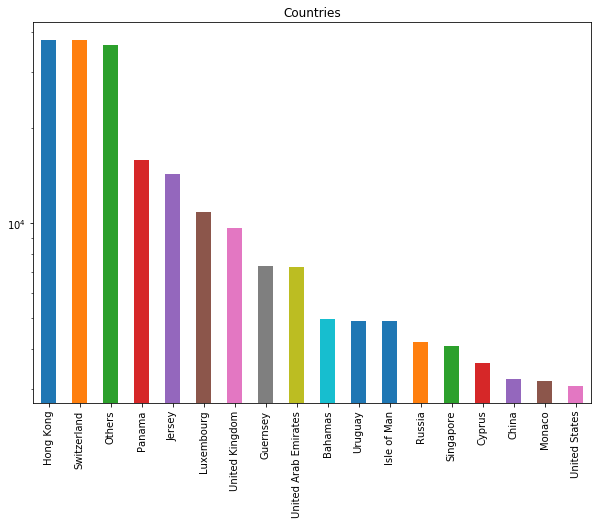

In [20]:
df_entity_S1.countries.value_counts().plot(kind='bar',title='Countries', figsize=(10, 7), logy=True)

The value of the `Others` column is very high indicating a quite heavy tail distribution. As before, plotting the bar chart with a logarithm $y-axis$, seems that the distribution has a exponential behaviour at least his first part. 

Lastly a world map is plotted again following the same Mercator Projection techinque used above.

In [24]:
# do the same for countries, filtering by countries > 1000

s = df_entity_raw.countries.value_counts()
s = s[s > 1000]
country_df = pd.DataFrame(s).reset_index()
country_df.columns = ['Area', 'Count']

c_lat = []
c_long = []

for ind, row in country_df.iterrows():
    location = geolocator.geocode(row['Area'])
    c_lat.append(location.latitude)
    c_long.append(location.longitude)

country_df['Latitude'] = c_lat
country_df['Longitude'] = c_long

x_y_c = merc(country_df.Latitude, country_df.Longitude)
country_df['x'] = x_y_c[0]
country_df['y'] = x_y_c[1]

output_file("proj_jekyll/assets/country_map.html", title="country_map")
plot_map(country_df, "Top countries that have offshore entities")

Loading BokehJS ...

An interesting fact can be noticed from the distribution of the countries. The majority of the entities present in the papers come from a country with already favourable business condition like Honk Kong, Switzerland and Luxembourg or even from a place considered a fiscal paradise (Panama, Jersey). 
More analysis on this aspect will be performed, but generally business friendly business conditions correspond with very low tax rate. In other words the  countries with highest number of entities offshore are coming from tax haven countries.

This fact could also be explained with a tendency, amplified by globalization, of big companies of starting their international business already from a convenient economy; however in order to comfirm this claim a stakeholder analysis should be done and for this reason we are not going to focus on this question.

# Structure of the investigation

## Investigation outline

As now it was understood that the major presence in the Panama Papers is characterized by tax havens countries, it is important to comprehend what are the business and economical conditions which influence entities to go offshore on a global level and why tax havens are such an good place to then go offshore. Hence, in order to answer to questions 3 and 4, the following structure is going to be  kept. It is important to mention that all the following investigations are not only done on a global scale, but with the help of the GDP data, the relationship between the set of economical and bureaucratic indicators and the number of offshore entities are inspected for different set of countries. The categories identified are 'Small developed countries', 'Developing Countries', 'Seven Biggest Economies' and 'Developed Countries'.
Eventually it is important to mention that an average of the indicators in the past 15 years is considered for each country in order to fully exploit the data. In order to explore the role of each indicator, interactive plots are created to better investigate individually what are the conditions which push entities to go offshore.

The following steps will be performed in this order throughout the notebook. 

- The GDP data is integrated with external values allowing a left join with the Panama Papers without leaving any entry without defined value.   
- The corporate tax is investigated as a determinant of offshore companies.
- Similar analysis as before are performed with days to open a business and time spent in regulations database.
- The amount of corporate taxes lost is analysed country by country.
- GINI time relation wiht numbers of Panama Papers is investigated.

## Assumptions

In our analysis some assumtions will be made:

- Countries categorization used in the analysis are created arbitrarily following common criteria.
- The whole dataset of Panama Papers is considered for country by country analysis even if not all refer to recent years.
- The largest part of the entities in the entity database is considered to be companies and businesses. 
- Indicators change in 15 year but the average over this period si still significant as indicator of economic activity.
- GDP is used as a measure of economic activity and power.
- It is assumed that all the entities present in the papers correspond to the biggest share of a company and they are not just a small share holding.
 
The way in which the countries are categorized, although being arbitrarily, follow other categorizations diffused in the sociological and economic analysis. The second and forth assumption are linked to each other as basically an average of both data is taken. This can be considered correct as, even if the two periods of time considered not match, the largest amount of Panama Papers are concentrated in recent period. All the entries of entity database are considered as companies as even if they are referring to private households, they are still register as companies. GDP is quite a fair measure of the economic weight of a country as it describes the market value of all the final goods and services produced, in this case, yearly. Eventually concerning the last assumption often times companies present in the Panama Papers correspond to holdings placed in offshore jurisdiction which represent a percentage of the total company.  In this case it was assumed that they always represent the biggest share. This means their presence in a country directly implies their taxes will be paied in that country.

## GDP Data Integration

In order to go further with the investigation it is crucial to have an instrument to distinguish between categories of countries. The parameters used to do so are the Total Gross Domestic Product and the Gross Domestic Product per capita which are measures of the size of the economic activity in a country and population. Hence, using these two paramters the number of entities present in the Panama Papers will be weighted according to these indicators too.

$GDP_{cap}$

As many of the operation performed with the GDP will involve an inner joint between the latter and the entity data frame, the correctness of the operation is investigated. 

In [25]:
df_GDP_tot_raw.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.330168e+09,1.320670e+09,1.379888e+09,1.531844e+09,1.665363e+09,1.722799e+09,1.873453e+09,1.920263e+09,1.941095e+09,2.021302e+09,2.228279e+09,2.331006e+09,2.421475e+09,2.623726e+09,2.791961e+09,2.498933e+09,2.467704e+09,2.584464e+09,NaN,NaN,2.516000e+09,NaN,NaN,NaN
1,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,537777811.1,548888895.6,546666677.8,751111191.1,800000044.4,1.006667e+09,1.400000e+09,1.673333e+09,1.373333e+09,1.408889e+09,1.748887e+09,1.831109e+09,1.595555e+09,1.733333e+09,2.155555e+09,2.366667e+09,2.555556e+09,2.953333e+09,3.300000e+09,3.697940e+09,3.641723e+09,3.478788e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.461666e+09,4.128821e+09,4.583644e+09,5.285466e+09,6.275074e+09,7.057598e+09,9.843842e+09,1.019053e+10,1.248694e+10,1.593680e+10,1.793024e+10,2.053654e+10,2.026425e+10,2.061610e+10,1.921556e+10,1.946902e+10,2.081530e+10
2,Angola,AGO,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.930503e+09,5.550483e+09,5.550483e+09,5.784342e+09,6.131475e+09,7.553560e+09,7.072063e+09,8.083872e+09,8.769251e+09,1.020110e+10,1.122876e+10,1.060378e+10,8.307811e+09,5.768720e+09,4.438321e+09,5.538749e+09,7.526447e+09,7.648377e+09,6.506230e+09,6.152923e+09,9.129595e+09,8.936064e+09,1.249735e+10,1.418895e+10,1.964085e+10,2.823371e+10,4.178948e+10,6.044892e+10,8.417804e+10,7.549239e+10,8.252614e+10,1.040000e+11,1.140000e+11,1.250000e+11,1.270000e+11,1.030000e+11,9.533720e+10,1.240000e+11
3,Albania,ALB,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.924242e+09,1.965385e+09,2.173750e+09,2.156625e+09,2.126000e+09,2.335125e+09,2.101625e+09,1.139167e+09,7.094526e+08,1.228071e+09,1.985674e+09,2.424499e+09,3.314898e+09,2.359903e+09,2.707124e+09,3.414761e+09,3.632044e+09,4.060759e+09,4.435079e+09,5.746946e+09,7.314865e+09,8.158549e+09,8.992642e+09,1.070101e+10,1.288135e+10,1.204421e+10,1.192695e+10,1.289087e+10,1.231978e+10,1.277628e+10,1.322824e+10,1.138693e+10,1.188368e+10,1.303935e+10
4,Andorra,AND,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.861921e+07,8.940982e+07,1.134082e+08,1.508201e+08,1.865587e+08,2.201272e+08,2.272810e+08,2.540202e+08,3.080089e+08,4.115783e+08,4.464161e+08,3.889587e+08,3.758960e+08,3.278618e+08,3.300707e+08,3.467380e+08,4.820006e+08,6.113164e+08,7.214259e+08,7.954493e+08,1.029048e+09,1.106929e+09,1.210014e+09,1.007026e+09,1.017549e+09,1.178739e+09,1.223945e+09,1.180597e+09,1.211932e+09,1.239876e+09,1.434430e+09,1.496913e+09,1.733117e+09,2.398646e+09,2.935659e+09,3.255789e+09,3.543257e+09,4.016972e+09,4.007353e+09,3.660531e+09,3.355695e+09,3.442063e+09,3.164615e+09,3.281585e+09,3.350736e+09,2.811489e+09,2.877312e+09,3.012914e+09


All the following numbers printed show the condition of the data frame as it is right now, after performing the operation later described. The year with less missing values among the ones that follow the 2008 economic crisis (meaning comparable GDP to the present ones) is chosen as measure of the GDP. It is 2014 with 16 missing values.

In [26]:
print(df_GDP_tot_raw['2017'].isna().sum())
print(df_GDP_tot_raw['2016'].isna().sum())
print(df_GDP_tot_raw['2015'].isna().sum())
print(df_GDP_tot_raw['2014'].isna().sum())
print(df_GDP_tot_raw['2013'].isna().sum())
print(df_GDP_tot_raw['2012'].isna().sum())

30
23
18
9
16
17


In [27]:
df_GDP_tot=df_GDP_tot_raw[['Country Name','2014']].copy()
df_GDP_tot.columns = ['countries', 'GDP_tot']
#df_GDP_tot

A new data frame from the `entity` one is created with only the relevant columns. (value_counts is applied) 

In [28]:
df_vc=pd.DataFrame(df_entity_raw.countries.value_counts())
df_vc.reset_index(level=0, inplace=True)
df_vc.columns = ['countries', 'n_companies']
#df_vc

Now a merge with an inner join the value counts data frame `df_vc` and the `df_GDP_tot` is performed. All the lines with a missing GDP were visualized below (lines of British Virgin Islands, Turks and Caicos Island, Sint Marteen (dutch part), Monaco, Gibraltar, Cayman Islands, Bermuda and Aruba).  The missing values are manually integrated in the `.csv` looking at reliable data online. The check for nan values now shows an empty dataframe.

In [29]:
df_GDP_tot_entities=df_GDP_tot.merge(df_vc, how='inner',left_on='countries', right_on='countries')
print('Number of countries without GDP in the database: ',df_GDP_tot_entities[df_GDP_tot_entities['GDP_tot'].isna()])
#df_GDP_tot_entities

Number of countries without GDP in the database:  Empty DataFrame
Columns: [countries, GDP_tot, n_companies]
Index: []


$GDP_{tot}$

The same analysis procedure is performed on the GDP pro capita data frame. The same lines of GDP were missing, and they were replaced in the same manner as for the total GDP.

In [30]:
df_GDP_cap_raw.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17342.471940,16441.790640,16585.195530,17926.572840,19081.351660,19356.203390,20620.700630,20670.655660,20434.299440,20834.510200,22567.824920,23302.831990,24014.944270,25921.026050,27546.899390,24631.434860,24271.940420,25324.720360,NaN,NaN,25300.000000,NaN,NaN,NaN
1,Afghanistan,AFG,GDP per capita (current US$),NY.GDP.PCAP.CD,59.777327,59.878153,58.492874,78.782758,82.208444,101.290471,137.899362,161.322,129.506654,129.798541,157.187422,160.372836,136.117014,144.110319,174.942038,187.975604,199.026173,226.005344,249.287386,277.900742,274.880859,266.493042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.409691,187.845095,198.728544,219.141353,250.294130,272.563077,369.835796,373.361116,445.893298,553.300289,603.537023,669.009051,638.612543,629.345250,569.577923,561.778746,585.850064
2,Angola,AGO,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,664.117560,600.408766,579.252001,582.420126,596.602467,711.992700,647.563354,720.598939,761.618458,862.509058,922.550170,844.691134,640.622298,430.381595,320.657792,388.166766,512.620966,506.884952,419.639845,385.768854,555.296942,526.168743,711.181789,779.468317,1041.087109,1443.991924,2062.415212,2878.837305,3868.579014,3347.844900,3531.416878,4299.008136,4539.467689,4804.633826,4707.578098,3683.552607,3308.772828,4170.312280
3,Albania,ALB,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,662.520052,662.914793,719.157296,699.384292,676.566733,723.409610,639.463899,348.711318,218.492166,380.527371,619.065163,760.559376,1046.358511,749.584649,865.302162,1098.425463,1175.788981,1326.970339,1453.642777,1890.681557,2416.588235,2709.142931,3005.012903,3603.013685,4370.539647,4114.136545,4094.358832,4437.178068,4247.614308,4413.081697,4578.666728,3952.830781,4131.872341,4537.862492
4,Andorra,AND,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3238.556850,3498.173652,4217.173581,5342.168560,6319.739034,7169.101006,7152.375134,7751.370216,9129.706185,11820.849390,12377.411650,10372.232830,9610.266308,8022.654781,7728.906695,7774.393829,10361.815980,12616.167570,14304.356960,15166.437850,18878.505970,19532.540150,20547.711790,16516.471030,16234.809010,18461.064860,19017.174590,18353.059720,18894.521500,19261.710500,21936.530100,22228.846490,24741.493570,32776.442270,38503.479610,41282.020120,43748.772160,48582.808460,47785.659090,43339.379870,39736.354060,41098.766940,38391.080870,40619.711300,42294.994730,36038.267600,37231.815670,39146.548840


In [31]:
print(df_GDP_tot_raw['2017'].isna().sum())
print(df_GDP_tot_raw['2016'].isna().sum())
print(df_GDP_tot_raw['2015'].isna().sum())
print(df_GDP_tot_raw['2014'].isna().sum())
print(df_GDP_tot_raw['2013'].isna().sum())
print(df_GDP_tot_raw['2012'].isna().sum())

30
23
18
9
16
17


In [32]:
df_GDP_cap=df_GDP_cap_raw[['Country Name','2014']].copy()
df_GDP_cap.columns = ['countries', 'GDP_cap']
#df_GDP_cap

In [33]:
df_GDP_cap_entities=df_GDP_cap.merge(df_vc, how='inner',left_on='countries', right_on='countries')
print('Number of countries without GDP in the database: ',df_GDP_cap_entities[df_GDP_cap_entities['GDP_cap'].isna()])
df_GDP_cap_entities.head()

Number of countries without GDP in the database:  Empty DataFrame
Columns: [countries, GDP_cap, n_companies]
Index: []


,countries,GDP_cap,n_companies
0,Aruba,25300.000000,27
1,Angola,4707.578098,10
2,Albania,4578.666728,2
3,Andorra,42294.994730,489
4,United Arab Emirates,44443.061510,7269


## 3) What drives entities to go offshore and consequently how does that affect the country?

### Dataframe preparation

Firstly a dataframe with the country and the respective number of entities in the Panama Papers is made `country_count`. This is used as a base to subsequentially add information regarding the indicators.

In [34]:
country_count=pd.DataFrame(df_entity_mod_raw['countries'].value_counts())

In [35]:
country_count=country_count.rename(columns={'countries': 'n_companies_offshore'})
country_count['Country Name']=country_count.index
country_count=country_count.reset_index(drop=True)

In [36]:
country_count.head()

,n_companies_offshore,Country Name
0,37911,Switzerland
1,37911,"Hong Kong SAR, China"
2,21658,Channel Islands
3,15811,Panama
4,10840,Luxembourg


In order to investigate the causes pushing entities to go offshore, the number of entities per country has often to be weighted according to economical size: without doing so, big economies will automatically have a higher number of entities registered in the papers only because they are bigger. Hence GDP and GDP per capita are going to be used as weighting factor for the number of registered entities in papers, n in many analysis: 

\begin{equation*}
n_{w}=\frac{n}{GDP_{indicator}}
\end{equation*}

Hence dataframes for total GDP (`df_gdp`) and GDP per capita (`df_GDP_capita`) per countries are created and merged with `country_count`; this is not only useful as mentioned above to weight for the different sizes of the economies, but also to distinguish groups of countries according to their economies.

In [37]:
df_gdp=df_GDP_tot_raw.copy()

In [38]:
df_countries_gdp=pd.DataFrame({'Country Name':df_gdp['Country Name'],'GDP':df_gdp.iloc[:,range(-15,0)].mean(axis=1,numeric_only=True)})
# print(np.sum(df_countries_gdp['GDP'].isnull()))
# df_gdp=df_gdp[df_gdp['GDP'].notnull()]

Showing the missing values of GDP

In [39]:
df_countries_gdp[df_countries_gdp['GDP'].isnull()]

,Country Name,GDP
49,Curacao,NaN
108,Not classified,NaN
145,St. Martin (French part),NaN
170,New Caledonia,NaN
191,"Korea, Dem. People?s Rep.",NaN
197,French Polynesia,NaN


In [40]:
df_gdp_capita=df_GDP_cap_raw.copy()

In [41]:
df_countries_gdp_capita=pd.DataFrame({'Country Name':df_gdp_capita['Country Name'],'GDP':df_gdp_capita.iloc[:,range(-15,0)].mean(axis=1,numeric_only=True)})

Before starting the analysis is fundamantal to check which countries don't have total GDP values

In [42]:
df_countries_gdp_capita[df_countries_gdp_capita['GDP'].isnull()]

,Country Name,GDP
49,Curacao,NaN
108,Not classified,NaN
145,St. Martin (French part),NaN
170,New Caledonia,NaN
191,"Korea, Dem. People?s Rep.",NaN
197,French Polynesia,NaN


In [43]:
# count in panama papers and gdp is merged in one dataframe
country_count_gdp=country_count.merge(df_countries_gdp, how='outer',left_on='Country Name', right_on='Country Name')

In [44]:
# count in panama papers and gdp per capita is merged in one dataframe
country_count_gdp=country_count_gdp.merge(df_countries_gdp_capita, how='outer',left_on='Country Name', right_on='Country Name')

In [45]:
country_count_gdp.head()

,n_companies_offshore,Country Name,GDP_x,GDP_y
0,37911.0,Switzerland,5.693333e+11,72018.654377
1,37911.0,"Hong Kong SAR, China",2.420000e+11,34139.405171
2,21658.0,Channel Islands,9.180788e+09,59422.543726
3,15811.0,Panama,3.405630e+10,9062.889846
4,10840.0,Luxembourg,5.192631e+10,100087.833141


Before starting the analysis is also important to check which countries don't have per capita GDP values. Except for Taiwan, the other countries didn't have a large presence in the papers so they were discarded.

In [46]:
country_count_gdp['Country Name'][country_count_gdp['GDP_y'].isna()]

16                        Taiwan
40                          Niue
80                       Curacao
150                 Cook Islands
200               Not classified
213     St. Martin (French part)
225                New Caledonia
233    Korea, Dem. People?s Rep.
237             French Polynesia
Name: Country Name, dtype: object

### Tax Rate on income, profits and capital gains

It is probable that entities from all over the world are firstly influenced to go set their businesses already in countries which offer particularly good business conditions such as Switzlerand, Panama, the Channel Islands (Jersey and Guernsey), Luxemburg, the Cayman Islands, Lichteinstein, Singapore and Monaco, Isle of Man and Gibraltar. These countries are known for being small and very developed with high income per capita, but also to often be tax havens. 


Hence, on the one hand it is crucial to understand what are these business conditions (economic and bureaucratic) that make this set of countries the optimum place to do business, but also to easily go offshore and on the other hand what are the economic and bureaucratic causes which influence entities in the other countries to go offshore. 

The first factor which is going to be investigated is an average of tax Rate on income, profits and capital gains; this indicator was used to take into account both corporate and capital tax rate, but also income to mitigate for the fact that not all entities in the Panama Papers are companies. In other words it is going to be investigated whether or not having a high tax rate influence entities and especially companies to go offshore in jurisdictions offering them important advantages in terms of tax savings.

Firstly the sparsity of the data is checked by querying what is the year with the highest number of data.

In [47]:
years=range(1990, 2018)
years_count=np.array([])

for year in years:
    
    years_count=np.append(years_count,df_tax_rate[str(year)].notnull().sum())
print ('Year with most data is', years[np.argmax(years_count)])

Year with most data is 2010


In order to fully exploit the data, the average tax rate for each country is computed over a time frame of 15 years; hence it is assumed that any change in corporate tax in this time range has not affected the number of entities going offshore in this time range.

In [48]:
df_countries_tax=pd.DataFrame({'Country Name':df_tax_rate['Country Name'],'Tax Rate':df_tax_rate.iloc[:,range(-15,0)].mean(axis=1,numeric_only=True)})

In [49]:
df_countries_tax.head()

,Country Name,Tax Rate
0,Aruba,NaN
1,Afghanistan,3.718429
2,Angola,40.648405
3,Albania,14.046091
4,Andorra,NaN


A dataset with tax rate and number of companies registered in the panama papers is made.

In [50]:
country_count_tax_rate=country_count_gdp.merge(df_countries_tax, how='outer',left_on='Country Name', right_on='Country Name')

Then for countries having a presence in Panama Papers higher than 1000 whose tax rate was missing the, an ad hoc research was done; hence individual values of corporate tax rates were added for the countries listed below since they had a consistent proportion of entities offshore.

In [51]:
country_count_tax_rate[country_count_tax_rate['Tax Rate'].isna()].head(10)

,n_companies_offshore,Country Name,GDP_x,GDP_y,Tax Rate
1,37911.0,"Hong Kong SAR, China",2.420000e+11,34139.405171,NaN
2,21658.0,Channel Islands,9.180788e+09,59422.543726,NaN
3,15811.0,Panama,3.405630e+10,9062.889846,NaN
6,7269.0,United Arab Emirates,2.939333e+11,39757.577518,NaN
7,4984.0,"Bahamas, The",1.048800e+10,29218.051776,NaN
9,4892.0,Isle of Man,5.216144e+09,65308.380697,NaN
14,3168.0,Monaco,5.301932e+09,148406.483360,NaN
16,2725.0,Taiwan,NaN,NaN,NaN
17,2066.0,Liechtenstein,4.922173e+09,136708.283262,NaN
18,2039.0,Gibraltar,2.288000e+09,92843.000000,NaN


Substitute the tax rate where NaN is present by integrating the data with additional sources. In particular the tax rate in the channel island Jersey and Guersey, in the Isle of Man, Monaco, Lichtenstein, Gibraltar, Hong Kong, British Vergin Islands, United Arab Emirates, Bahamas and Ecuador have been looked up. An average for a tax rate on income, profits and capital gains wasn't found for each country individually; as a consequence corporate tax rate were considered according to the assumption that all the entities in the papers are assumed to be companies.

- Jersey and Guernesey as part of the channel islands have a corporate tax rate of 0% with exeption for some kind of businesses with maximum values of 20% [Jersey](https://www.gov.je/LifeEvents/MovingToJersey/pages/tax.aspx), [Guernsey](https://www.gov.gg/article/120167/Tax-for-businesses-companies-and-employers)

- Isle of Man has a corporate tax rate of 0% with exeption for some kind of businesses with maximum values of 20% [Isle of Man](https://www.gov.im/categories/tax-vat-and-your-money/income-tax-and-national-insurance/business-and-corporations/corporate-tax-rates/)

- Monaco has a corporate tax rate of 0% [Monaco](https://www.investopedia.com/ask/answers/060316/why-monaco-considered-tax-haven.asp)

- Lichtenstein has a corporate tax rate of 12.5% [Lichtenstein](http://taxsummaries.pwc.com/ID/Liechtenstein-Corporate-Taxes-on-corporate-income)

- Gibraltar has a corporate tax rate of 10% [Gibraltar](https://www.ey.com/Publication/vwLUAssets/ey-gibraltar-tax-facts-2017-18/$FILE/ey-gibraltar-tax-facts-2017-18.pdf)

- Hong Kong have a corporate tax rate of 16.5% [Hong Kong](https://tradingeconomics.com/hong-kong/corporate-tax-rate)

- British Vergin Islands have a corporate tax rate of 0% [British Vergin Islands](https://www2.deloitte.com/content/dam/Deloitte/global/Documents/Tax/dttl-tax-britishvirginislandshighlights-2018.pdf?nc=1)

- United Arab Emirates have a corporate tax rate of 0% [United Arab Emirates](https://en.portal.santandertrade.com/establish-overseas/united-arab-emirates/tax-system)

- Bahamas have a corporate tax rate of 0% [Bahamas](https://tradingeconomics.com/bahamas/personal-income-tax-rate)

- Ecuador have a corporate tax rate of 22% [Ecuador](https://tradingeconomics.com/ecuador/corporate-tax-rate)

No consistent information regarding Taiwan has been found for the lack of transparency of the Chinese government.


In [52]:
country_count_tax_rate.loc[country_count_tax_rate['Country Name']=='Channel Islands','Tax Rate']=0
country_count_tax_rate.loc[country_count_tax_rate['Country Name']=='Isle of Man','Tax Rate']=0
country_count_tax_rate.loc[country_count_tax_rate['Country Name']=='Monaco','Tax Rate']=0
country_count_tax_rate.loc[country_count_tax_rate['Country Name']=='Liechtenstein','Tax Rate']=12.5
country_count_tax_rate.loc[country_count_tax_rate['Country Name']=='Gibraltar','Tax Rate']=10
country_count_tax_rate.loc[country_count_tax_rate['Country Name']=='Hong Kong SAR, China','Tax Rate']=16.5
country_count_tax_rate.loc[country_count_tax_rate['Country Name']=='Bahamas, The','Tax Rate']=0
country_count_tax_rate.loc[country_count_tax_rate['Country Name']=='United Arab Emirates','Tax Rate']=0
country_count_tax_rate.loc[country_count_tax_rate['Country Name']=='Ecuador','Tax Rate']=22
country_count_tax_rate.loc[country_count_tax_rate['Country Name']=='British Virgin Islands','Tax Rate']=0

#### Small Developed Countries

Firstly the graph of tax rate and presence in Panama Paper of small developed countries with high income per capita is plotted. In fact, by looking at these relationship it will be possible to understand if all small developed countries with high income per capita present favourable characteristics to go offshore. 

All the countries with GDP per capita `GDP_y`>30000 and a total GDP `GDP_x`< 200 billions USD have been considered.

The GDP has been used as a weight for the count of entities offshore because the discrepancy between the size of the economies is really high.

By observing the plot below some important considerations can be drawn; two set of countries can be identified: tax havens countries and small developed countries. Firstly the tax havens countries can be identified very easily since they have a high presence in the papers and at the same time they have really low tax rates. The rest of the countries are small developed usually European countries. The trend of non tax havens countries shows that high tax rate is not a factor pushing entities to go offshore; in fact the opposite could be true: there seems to be a negative exponential relationship between presence in panama papers and tax rates, but the two tail test p-value (0.395) of such relationship seems to imply that no relationship exist between tax rate and number of entities in Panama Papers for small developed countries. However this relationship could imply the presence of an hidden covariate: high tax rate might be synonym of tighter control and regulations on entities going offshore, meaning that countries with tighter controls will naturally have a lower number of offshore companies.

In addition the graph also seems to suggest that the resons behind the presence of many companies offshore in tax havens is not only the low taxation levels: in fact corporate tax rate of tax havens countries is often comparable to that one of other small european countries. As a matter of fact tax havens countries offer entities favorable conditions to easily set compabies offshore compared to other small countries.

In [53]:
selection=country_count_tax_rate['GDP_y'].apply(lambda x: x>30000) & country_count_tax_rate['GDP_x'].apply(lambda x: x<200*10e9)

x = country_count_tax_rate['Tax Rate'][selection]
y = np.log10(country_count_tax_rate['n_companies_offshore'][selection]/country_count_tax_rate['GDP_x'][selection])
country_names=country_count_tax_rate['Country Name'][selection]
c = country_count_tax_rate['GDP_x'][selection]
c[c.isna()]=0

# establish the color mapper schema
color_mapper = LogColorMapper(palette="Colorblind3", low=min(c),\
                              high=max(c))

# establish the sources of data to make the interactive graph
source=ColumnDataSource(data=dict(
    x=list(x),
    y=list(y),
    country=list(country_names),
    c=list(c),
))

    
# set the regression line
df=pd.DataFrame({'Tax Rate':x,'n_companies_offshore':y})
df=df.dropna(inplace=False)
df=df[df['n_companies_offshore'].apply(lambda x: x<-8)]

a=np.array(df['Tax Rate'])
b=np.array(df['n_companies_offshore'])

m,i,r,p_value,std=stats.linregress(a,b)

p = figure(title="Number of entities offshore vs tax rate (Small developed countries)", plot_width=800, plot_height=800)

scatter=p.scatter(x='x', y='y', radius=1, source=source, color={'field': 'c', 'transform': color_mapper}, alpha=0.5)
hover= HoverTool(tooltips = [("Country", "@country"),("(Tax Rate, Log(number of entities offshore))", "($x, $y)")],renderers=[scatter])
p.add_tools(hover)


line=p.line(df['Tax Rate'], m*df['Tax Rate']+i, line_width=4, color='navy', alpha=0.1)
hover0=HoverTool(tooltips = [("Set of Country",'Not tax havens countries, p-value='+str(p_value)[:5])], renderers=[line])
p.add_tools(hover0)
circle=p.circle(19, -6.6, size=450, color="navy", alpha=0.1)
hover1=HoverTool(tooltips = [("Set of Country",'Tax havens')], renderers=[circle])
p.add_tools(hover1)


# set the style of the title
p.title.text_color = "grey"
p.title.text_font = "helvetica"
p.title.text_font_style = "normal"
p.title.text_font_size = '11pt'

# set the label options
p.xaxis.axis_label='Tax Rate (%)'
p.yaxis.axis_label='Number of Entities Offshore (log scale)'

# add the color bar
color_bar = ColorBar(color_mapper=color_mapper, ticker=LogTicker(),
                     label_standoff=12, border_line_color=None, location=(20,0))

# set the color bar title
color_bar_height = 511
color_bar_width = 35

color_bar_plot = figure(title="Real GDP Legend Bar (USD)", title_location="right", 
                        height=color_bar_height, width=color_bar_width, 
                        toolbar_location=None, min_border=None, 
                        outline_line_color=None)

p.add_layout(color_bar, 'right')

# remove the interactive toolbar
p.toolbar.logo = None
p.toolbar_location = None

layout = row_plot(p, color_bar_plot)
output_file("taxratesmalldevelopedcountries.html", title="taxratesmalldevelopedcountries")
show(layout)

#### Developing Countries

Secondly the graph of tax rate and presence in Panama Paper of developing countries is plotted. BRICs countries have been considered, as well as all other countries which had a GDP greater than 40 billions USD a year. Also in this case the GDP has been used as a weight for the count of entities offshore because the discrepancy between the size of the economies is really high.

By observing this graphs a negative exponential relationship can be again observed further showing that for this category of countries tax rate is not a factor pushing entities to go offshore: actually the higher the tax rate the lower the number of companies offshore. Contrary to the little evidence found in small developed countries, developing countries show a very clear negative exponential relationship with a two tails p-value of 0.00143. This could be a further proof to the hypothesis that higher tax rates are correlates with higher regulations as shown in the graph for small developed countries; in fact in developing countries the bureaucratic machine and regulation could even disable further entities who are willing to go offshore.

In [54]:
selection=country_count_tax_rate['GDP_y'].apply(lambda x: x<15000) & country_count_tax_rate['GDP_x'].apply(lambda x: x>40*10e9)

x = country_count_tax_rate['Tax Rate'][selection]
y = np.log10(country_count_tax_rate['n_companies_offshore'][selection]/country_count_tax_rate['GDP_x'][selection])
country_names=country_count_tax_rate['Country Name'][selection]
c = country_count_tax_rate['GDP_x'][selection]
c[c.isna()]=0

# set the regression line
df=pd.DataFrame({'Tax Rate':x,'n_companies_offshore':y})
df=df.dropna(inplace=False)
a=np.array(df['Tax Rate'])
b=np.array(df['n_companies_offshore'])

m,i,r,p_value,std=stats.linregress(a,b)


# establish the color mapper schema
color_mapper = LogColorMapper(palette="Colorblind4", low=min(c),\
                              high=max(c))

# establish the sources of data to make the interactive graph
source=ColumnDataSource(data=dict(
    x=list(x),
    y=list(y),
    country=list(country_names),
    c=list(c),
))

p = figure(title="Number of entities offshore vs tax rate (Major developing countries)", plot_width=800, plot_height=800)
scatter=p.scatter(x='x', y='y', radius=1, source=source, color={'field': 'c', 'transform': color_mapper}, alpha=0.5)
hover= HoverTool(tooltips = [("Country", "@country"),("(Tax Rate, Log(number of entities offshore))", "($x, $y)")],renderers=[scatter])
p.add_tools(hover)

line=p.line(df['Tax Rate'], m*df['Tax Rate']+i, line_width=4, color='navy', alpha=0.1)
hover0=HoverTool(tooltips = [("Set of Country",'Developing countries, p-value='+str(p_value)[:5])], renderers=[line])
p.add_tools(hover0)

# set the style of the title
p.title.text_color = "grey"
p.title.text_font = "helvetica"
p.title.text_font_style = "normal"
p.title.text_font_size = '11pt'

# set the label options
p.xaxis.axis_label='Tax Rate (%)'
p.yaxis.axis_label='Number of Entities Offshore (log scale)'


# set the color bar tab
color_bar = ColorBar(color_mapper=color_mapper, ticker=LogTicker(),
                     label_standoff=12, border_line_color=None, location=(0,0))

# set the color bar title
color_bar_height = 511
color_bar_width = 35

color_bar_plot = figure(title="Real GDP Legend Bar (USD)", title_location="right", 
                        height=color_bar_height, width=color_bar_width, 
                        toolbar_location=None, min_border=None, 
                        outline_line_color=None)

# add the color bar
p.add_layout(color_bar, 'right')

# remove the interactive toolbar
p.toolbar.logo = None
p.toolbar_location = None

layout = row_plot(p, color_bar_plot)
output_file("developingcountries.html", title="developingcountries")
show(layout)

#### Seven Biggest Economies

Graph of the biggest economies. The relationship between the 7 biggest economies and tax rate has been investigated. The economies almost correspond to the G7 countries, but China has taken the place of Canada. Even though these are the biggest economies in the world, the difference in size between them influence the probability of creating business and hence having companies offshore. As a consequence also in this case the GDP was used to weight the number of offshore entities present in the panama papers. 

All the countries with a total GDP `GDP_x`> 200 billions USD have been considered.

The figure below shows a completely different picture, compared to the previous ones: taking out Japan, it seems to be a positive exponential relationship between tax rate and number of offshore entities for the economically strongest countries suggesting that in these countries (p-value=0.531), entities are escaping corporate taxation levels by putting their companies offshore. Japan represents an exception among the 7 biggest economies: even though it has a very high tax rate, the presence of Japanese entities in the documents is really low. This could be due to cultural reasons or might be due to the fact that Japanese entities use different means to go offshore and they are not very represented in the Panama Papers themselves.

In [55]:
selection=country_count_tax_rate['GDP_x'].apply(lambda x: x>200*10e9)
x = country_count_tax_rate['Tax Rate'][selection]
y = np.log10(country_count_tax_rate['n_companies_offshore'][selection]/country_count_tax_rate['GDP_x'][selection])
country_names=country_count_tax_rate['Country Name'][selection]

# establish the sources of data to make the interactive graph
source=ColumnDataSource(data=dict(
    x=list(x),
    y=list(y),
    country=list(country_names),
))

# set the regression line
df=pd.DataFrame({'Tax Rate':x,'n_companies_offshore':y, 'country_name':country_names})
df=df[df['country_name'].apply(lambda x: str(x)!='Japan')]
df=df.dropna(inplace=False)
a=np.array(df['Tax Rate'])
b=np.array(df['n_companies_offshore'])

m,i,r,p_value,std=stats.linregress(a,b)

p = figure(title="Number of entities offshore vs tax rate (G7 countries)", plot_width=800, plot_height=800)
scatter=p.scatter(x='x', y='y', radius=1, source=source, fill_alpha=0.6)
hover= HoverTool(tooltips = [("Country", "@country"),("(Tax Rate, Log(number of entities offshore))", "($x, $y)")],renderers=[scatter])
p.add_tools(hover)

line=p.line(df['Tax Rate'], m*df['Tax Rate']+i, line_width=4, color='navy', alpha=0.1)
hover0=HoverTool(tooltips = [("Set of Country",'Major biggest economies, p-value='+str(p_value)[:5])], renderers=[line])
p.add_tools(hover0)

# set the style of the title
p.title.text_color = "grey"
p.title.text_font = "helvetica"
p.title.text_font_style = "normal"
p.title.text_font_size = '11pt'

# set the label options
p.xaxis.axis_label='Tax Rate (%)'
p.yaxis.axis_label='Number of Entities Offshore (log scale)'

# remove the interactive toolbar
p.toolbar.logo = None
p.toolbar_location = None

output_file("taxrateg7.html", title="taxrateg7")

show(p)

#### Global Perspective

Eventually after having analyzed the above set of countries, the global picture for developed countries has been drawn. Observing the figure, on a global scale it can be seen that there is no significant correlation between corporate tax rate and presence of offshore entities in the Panama Papers. However it is clear the a positive relationship between tax rate and number of offshore entities holds true for the major economies which are the biggest data points.

In [56]:
selection=country_count_tax_rate['GDP_y']>15000
x=country_count_tax_rate['Tax Rate'][selection]
y=np.log10(country_count_tax_rate['n_companies_offshore'][selection])
radii=country_count_tax_rate['GDP_x'][selection]*10e-13
country_names=country_count_tax_rate['Country Name'][selection]
# for colors
c = country_count_tax_rate['GDP_y'][selection]
c[c.isna()]=0


color_mapper = LogColorMapper(palette="Colorblind4", low=min(c),\
                              high=max(c))

source=ColumnDataSource(data=dict(
    x=list(x),
    y=list(y),
    country=list(country_names),
    radii=list(radii),
    c=list(c),
))


# set the regression line
df=pd.DataFrame({'Tax Rate':x,'n_companies_offshore':y})
df=df.dropna(inplace=False)

a=np.array(df['Tax Rate'])
b=np.array(df['n_companies_offshore'])

m,i,r,p,std=stats.linregress(a,b)

p = figure(title="Number of entities offshore vs tax rate (all developed countries)", plot_width=800, plot_height=800)
scatter=p.scatter(x='x', y='y', radius='radii', source=source, color={'field': 'c', 'transform': color_mapper}, alpha=0.5)
hover= HoverTool(tooltips = [("Country", "@country"),("(Tax Rate, Log(number of entities offshore))", "($x, $y)")],renderers=[scatter])
p.add_tools(hover)

line=p.line(df['Tax Rate'], m*df['Tax Rate']+i, line_width=4, color='navy', alpha=0.1)
hover0=HoverTool(tooltips = [("Set of Country",'Trend in all developed countries')], renderers=[line])
p.add_tools(hover0)

# set the color bar tab
color_bar = ColorBar(color_mapper=color_mapper, ticker=LogTicker(),
                     label_standoff=12, border_line_color=None, location=(0,0))

# set the color bar title
color_bar_height = 511
color_bar_width = 35

color_bar_plot = figure(title="Real GDP per capita Legend Bar (USD)", title_location="right", 
                        height=color_bar_height, width=color_bar_width, 
                        toolbar_location=None, min_border=None, 
                        outline_line_color=None)


# set the style of the title
p.title.text_color = "grey"
p.title.text_font = "helvetica"
p.title.text_font_style = "normal"
p.title.text_font_size = '11pt'

# set the label options
p.xaxis.axis_label='Tax Rate (%)'
p.yaxis.axis_label='Number of Entities Offshore (log scale)'

# add the color bar
p.add_layout(color_bar, 'right')
                        
# remove the interactive toolbar
p.toolbar.logo = None
p.toolbar_location = None

layout = row_plot(p, color_bar_plot)
output_file("taxrate_developed.html", title="taxrate_developed")
show(layout)


### Days to open a  business

Another parameter that could influence entities to go offshore is the number of days needed to open a busines. This parameter, in fact, is another indicator of business conditions in a country: the hypothesis is that entities go offshore in order to find better business conditions that the home country cannot offer them. 

In [57]:
years=range(1990, 2018)
years_count=np.array([])

for year in years:
    
    years_count=np.append(years_count,df_ease_business[str(year)].notnull().sum())
print ('Year with most data is', years[np.argmax(years_count)])

Year with most data is 2015


In order to fully exploit the data, the average days to open a business for each country is computed over a time frame of 15 years; hence it is assumed that any change in days to open a business in this time range has not affected the number of entities going offshore in this time range.

In [58]:
#df_countries_ease_business=pd.DataFrame({'Country Name':df_ease_business['Country Name'][df_ease_business['2015'].notnull()],'days_open_business':df_ease_business['2015'][df_ease_business['2013'].notnull()]})
df_countries_ease_business=pd.DataFrame({'Country Name':df_ease_business['Country Name'],'days_open_business':df_ease_business.iloc[:,range(-15,0)].mean(axis=1,numeric_only=True)})
df_countries_ease_business=df_countries_ease_business[df_countries_ease_business['days_open_business'].notnull()]

A dataset with number of days to open a business and number of companies registered in the panama papers is made. However for this coefficient it was very hard to integrate the missing data values by using other sources. As a matter of fact the this analysis is limited to the countries which have the corporate tax rate values.

In [59]:
country_count_ease_business=country_count_gdp.merge(df_countries_ease_business, how='outer',left_on='Country Name', right_on='Country Name')

#### Small Developed Countries

Again firstly the graph of days to open a business and presence in Panama Paper of small developed countries with high income per capita is plotted. In fact, by looking at these relationship it will be possible to understand if all small developed countries with high income per capita present favourable characteristics to go offshore.

All the countries with GDP per capita `GDP_y`>30000 and a total GDP `GDP_x`< 200 billions USD have been considered.

The GDP has been used as a weight for the count of entities offshore because the discrepancy between the size of the economies is really high.

By observing the plot below some important considerations can be drawn; again the two set of countries can be identified: tax havens countries and small developed countries. The first ones are visibile since they have a very high number of offshore entities and the second group can be identified below. In this case it is not possible to determine whether days to open a business influence entities in countries to go offshore. Hence it seems that for this category of countries no dependency can be drawn. In fact even the regression line that should show a negative exponential relationship between days to open a business and number of entities in Panama Papers has a two tail test p-value of 0.837, which confirms the hypothesis that the slope of the line should be zero. 

In [60]:
selection=country_count_ease_business['GDP_y'].apply(lambda x: x>30000) & country_count_ease_business['GDP_x'].apply(lambda x: x<200*10e9)

x = np.log10(country_count_ease_business['days_open_business'][selection])
y = np.log10(country_count_ease_business['n_companies_offshore'][selection]/country_count_ease_business['GDP_x'][selection])
country_names=country_count_ease_business['Country Name'][selection]
c = country_count_ease_business['GDP_x'][selection]
c[c.isna()]=0

# establish the color mapper schema
color_mapper = LogColorMapper(palette="Colorblind3", low=min(c),\
                              high=max(c))

# establish the sources of data to make the interactive graph
source=ColumnDataSource(data=dict(
    x=list(x),
    y=list(y),
    country=list(country_names),
    c=list(c),
))

    
# set the regression line
df=pd.DataFrame({'days_open_business':x,'n_companies_offshore':y})
df=df.dropna(inplace=False)
df=df[df['n_companies_offshore'].apply(lambda x: x<-8)]

a=np.array(df['days_open_business'])
b=np.array(df['n_companies_offshore'])

m,i,r,p_value,std=stats.linregress(a,b)

p = figure(title="Number of entities offshore vs days to open a business(Small developed countries)", plot_width=800, plot_height=800)

scatter=p.scatter(x='x', y='y', radius=0.01, source=source, color={'field': 'c', 'transform': color_mapper}, alpha=0.5)
hover= HoverTool(tooltips = [("Country", "@country"),("(Tax Rate, Log(number of entities offshore))", "($x, $y)")],renderers=[scatter])
p.add_tools(hover)


line=p.line(df['days_open_business'], m*df['days_open_business']+i, line_width=4, color='navy', alpha=0.1)
hover0=HoverTool(tooltips = [("Set of Country",'Not tax havens countries, p-value='+str(p_value)[:5])], renderers=[line])
p.add_tools(hover0)
circle=p.circle(0.85, -7, size=370, color="navy", alpha=0.1)
hover1=HoverTool(tooltips = [("Set of Country",'Tax havens')], renderers=[circle])
p.add_tools(hover1)


# set the style of the title
p.title.text_color = "grey"
p.title.text_font = "helvetica"
p.title.text_font_style = "normal"
p.title.text_font_size = '11pt'

# set the label options
p.xaxis.axis_label='Days to open a business'
p.yaxis.axis_label='Number of Entities Offshore (log scale)'

# add the color bar
color_bar = ColorBar(color_mapper=color_mapper, ticker=LogTicker(),
                     label_standoff=12, border_line_color=None, location=(20,0))

# set the color bar title
color_bar_height = 511
color_bar_width = 35

color_bar_plot = figure(title="Real GDP Legend Bar (USD)", title_location="right", 
                        height=color_bar_height, width=color_bar_width, 
                        toolbar_location=None, min_border=None, 
                        outline_line_color=None)

p.add_layout(color_bar, 'right')

# remove the interactive toolbar
p.toolbar.logo = None
p.toolbar_location = None

layout = row_plot(p, color_bar_plot)
output_file("daysbusinesssmalldevelopedcountries.html", title="daysbusinesssmalldevelopedcountries")
show(layout)


#### Developing Countries

Secondly the graph of days to open a business and presence in Panama Paper of developing countries is plotted. BRICs countries have been considered, as well as all other countries which had a GDP greater than 40 billions USD a year. Also in this case the GDP has been used as a weight for the count of entities offshore because the discrepancy between the size of the economies is really high.

By observing this graphs it is immediately clear that no conclusion can be drawn from the data: days to open a business is not a factor influencing in any manner entities in this category of countries to go offshore. 

In [61]:
selection=country_count_ease_business['GDP_y'].apply(lambda x: x<15000) & country_count_ease_business['GDP_x'].apply(lambda x: x>40*10e9)

x = np.log10(country_count_ease_business['days_open_business'][selection])
y = np.log10(country_count_ease_business['n_companies_offshore'][selection]/country_count_ease_business['GDP_x'][selection])
country_names=country_count_ease_business['Country Name'][selection]
c = country_count_ease_business['GDP_x'][selection]
c[c.isna()]=0

# set the regression line
df=pd.DataFrame({'days_open_business':x,'n_companies_offshore':y})
df=df.dropna(inplace=False)
a=np.array(df['days_open_business'])
b=np.array(df['n_companies_offshore'])

m,i,r,p,std=stats.linregress(a,b)

# establish the color mapper schema
color_mapper = LogColorMapper(palette="Colorblind4", low=min(c),\
                              high=max(c))

# establish the sources of data to make the interactive graph
source=ColumnDataSource(data=dict(
    x=list(x),
    y=list(y),
    country=list(country_names),
    c=list(c),
))

p = figure(title="Number of entities offshore vs days to open a business (Major developing countries)", plot_width=800, plot_height=800)
scatter=p.scatter(x='x', y='y', radius=0.01, source=source, color={'field': 'c', 'transform': color_mapper}, alpha=0.5)
hover= HoverTool(tooltips = [("Country", "@country"),("(Tax Rate, Log(number of entities offshore))", "($x, $y)")],renderers=[scatter])
p.add_tools(hover)

line=p.line(df['days_open_business'], m*df['days_open_business']+i, line_width=4, color='navy', alpha=0.1)
hover0=HoverTool(tooltips = [("Set of Country",'Developing countries')], renderers=[line])
p.add_tools(hover0)

# set the style of the title
p.title.text_color = "grey"
p.title.text_font = "helvetica"
p.title.text_font_style = "normal"
p.title.text_font_size = '11pt'

# set the label options
p.xaxis.axis_label='Days to open a business'
p.yaxis.axis_label='Number of Entities Offshore (log scale)'


# set the color bar tab
color_bar = ColorBar(color_mapper=color_mapper, ticker=LogTicker(),
                     label_standoff=12, border_line_color=None, location=(0,0))

# set the color bar title
color_bar_height = 511
color_bar_width = 35

color_bar_plot = figure(title="Real GDP Legend Bar (USD)", title_location="right", 
                        height=color_bar_height, width=color_bar_width, 
                        toolbar_location=None, min_border=None, 
                        outline_line_color=None)

# add the color bar
p.add_layout(color_bar, 'right')

# remove the interactive toolbar
p.toolbar.logo = None
p.toolbar_location = None

layout = row_plot(p, color_bar_plot)
output_file("developingcountriesdaysbusiness.html", title="developingcountriesdaysbusiness")
show(layout)

#### Global Perspective

Eventually by plotting all the developed countries together it is not possible to find a global clear relationship between number of days to open a business and number of entities in Panama Papers. Hence it can be concludede that the hypothesis established at the beginning of the analysis has been contradicted.

In [62]:
selection=country_count_ease_business['GDP_y']>15000
x=np.log10(country_count_ease_business['days_open_business'][selection])
y=np.log10(country_count_ease_business['n_companies_offshore'][selection])
radii=country_count_ease_business['GDP_x'][selection]*10e-15 #13
country_names=country_count_ease_business['Country Name'][selection]
# for colors
c = country_count_ease_business['GDP_y'][selection]
c[c.isna()]=0


color_mapper = LogColorMapper(palette="Colorblind4", low=min(c),\
                              high=max(c))

source=ColumnDataSource(data=dict(
    x=list(x),
    y=list(y),
    country=list(country_names),
    radii=list(radii),
    c=list(c),
))


# set the regression line
df=pd.DataFrame({'days_open_business':x,'n_companies_offshore':y})
df=df.dropna(inplace=False)

a=np.array(df['days_open_business'])
b=np.array(df['n_companies_offshore'])

m,i,r,p_value,std=stats.linregress(a,b)

p = figure(title="Number of entities offshore vs days to open a business (all developed countries)", plot_width=800, plot_height=800)
scatter=p.scatter(x='x', y='y', radius='radii', source=source, color={'field': 'c', 'transform': color_mapper}, alpha=0.5)
hover= HoverTool(tooltips = [("Country", "@country"),("(Tax Rate, Log(number of entities offshore))", "($x, $y)")],renderers=[scatter])
p.add_tools(hover)

line=p.line(df['days_open_business'], m*df['days_open_business']+i, line_width=4, color='navy', alpha=0.1)
hover0=HoverTool(tooltips = [("Set of Country",'Trend in all developed countries, p-vaue='+str(p_value)[:5])], renderers=[line])
p.add_tools(hover0)

# set the color bar tab
color_bar = ColorBar(color_mapper=color_mapper, ticker=LogTicker(),
                     label_standoff=12, border_line_color=None, location=(0,0))

# set the color bar title
color_bar_height = 511
color_bar_width = 35

color_bar_plot = figure(title="Real GDP per capita Legend Bar (USD)", title_location="right", 
                        height=color_bar_height, width=color_bar_width, 
                        toolbar_location=None, min_border=None, 
                        outline_line_color=None)


# set the style of the title
p.title.text_color = "grey"
p.title.text_font = "helvetica"
p.title.text_font_style = "normal"
p.title.text_font_size = '11pt'

# set the label options
p.xaxis.axis_label='Days to open a business'
p.yaxis.axis_label='Number of Entities Offshore (log scale)'

# add the color bar
p.add_layout(color_bar, 'right')
                        
# remove the interactive toolbar
p.toolbar.logo = None
p.toolbar_location = None

layout = row_plot(p, color_bar_plot)
output_file("daysopenbusiness_developed.html", title="daysopenbusiness_developed")
show(layout)

### Time spent in regulations

Finally the last parameter that was thought to be influencing the number of offshore entities per country is the time that entities spend for regulation. In fact this could be an important reason for which companies could be established in offshore jurisdiction.

In [63]:
years=range(1990, 2018)
years_count=np.array([])

for year in years:
    
    years_count=np.append(years_count,df_time_regulation[str(year)].notnull().sum())
print ('Year with most data is', years[np.argmax(years_count)])

Year with most data is 2015


In order to fully exploit the data, the average time spent in regulation for each country is computed over a time frame of 15 years; hence it is assumed that any change in time spent in regulation in this time range has not affected the number of entities going offshore in this time range.

In [64]:
df_time_regulation=pd.DataFrame({'Country Name':df_time_regulation['Country Name'],'time_regulation':df_time_regulation.iloc[:,range(-15,0)].mean(axis=1,numeric_only=True)})
df_time_regulation=df_time_regulation[df_time_regulation['time_regulation'].notnull()]

In [65]:
df_time_regulation.head()

,Country Name,time_regulation
1,Afghanistan,8.071429
2,Angola,64.714286
3,Albania,15.357143
5,Arab World,26.151124
6,United Arab Emirates,13.350000


In [66]:
country_count_ease_regulation_time=country_count_gdp.merge(df_time_regulation, how='outer',left_on='Country Name', right_on='Country Name')

Even though the investigation of the parameter could be very interesting, the data provided by World Bank are too sparse and they don't provide  information about many countries. Hence the analysis is jeopardized. 

In [67]:
country_count_ease_regulation_time[country_count_ease_regulation_time['time_regulation'].isna()].head(10)

,n_companies_offshore,Country Name,GDP_x,GDP_y,time_regulation
2,21658.0,Channel Islands,9.180788e+09,59422.543726,NaN
9,4892.0,Isle of Man,5.216144e+09,65308.380697,NaN
14,3168.0,Monaco,5.301932e+09,148406.483360,NaN
16,2725.0,Taiwan,NaN,NaN,NaN
17,2066.0,Liechtenstein,4.922173e+09,136708.283262,NaN
18,2039.0,Gibraltar,2.288000e+09,92843.000000,NaN
29,1107.0,British Virgin Islands,8.500000e+08,34200.000000,NaN
37,489.0,Andorra,3.274308e+09,40705.073439,NaN
40,372.0,Niue,NaN,NaN,NaN
53,165.0,Bermuda,5.418704e+09,84080.952572,NaN


In conclusion it is clear that corporate tax is definitely a factor influencing entities to go offshore, but in different ways according to the set of countries considered. It seems that entities in the major economies are trying to escape high corporate taxation levels. While it seems that lower taxation levels in developing countries implies a higher number of companies set offshore. However it is hard to make inference statements since the correlations are often not strong enough and correlation doesn't imply causation. Also the other indicators explored such as days to open a business or time spent in regulation by businesses haven't led to the hoped results: further indicators should be explored, but the challenge of finding reliable global data has to be overcome.
 
Hence corporate tax rate is not the only determinant for entities to go offshore: in fact it was also concluded that corporate tax rate could actually be a proxy variable for other covariates. For instance it is clear that tax havens present ideal conditions for entities to set up offshore companies: additional research should be performed in finding what are theses bureaucratic and economical factors, but the lack of transparency of these countries makes it extremely to find useful data. 

## 4) What are the consequences of offshore companies on income inequality?

### OECD Corporate Tax: Amounts Lost

A last piece of analysis is to come up with a hypothesized number for the amount of corporate tax revenue lost for a country **assuming that the companies offshore are evading home corporate tax.** It is very important that we assume this because it is difficult to prove that these companies are evading tax (though it is the main hypothesized reason).

To do so, we obtained a [dataset from OECD](https://data.oecd.org/tax/tax-on-corporate-profits.htm) indicating the corporate tax rate % of GDP as well as a [dataset from NAICS](https://www.naics.com/business-lists/counts-by-country/) indicating the number of businesses per country. We can then calculate:

$$
Potential~Tax~Lost_{country} = \frac{Corporate~Tax~Revenue_{country}}{Number~Businesses_{country}} \times Number~ entities~in~PP_{country}
$$



In [68]:
# loading data

# GDP_tot = 'API_NY.GDP.MKTP.CD_DS2_en_csv_v2_10224782.csv'
# corp_tax_rate = 'corp_tax_rate.csv'
# business_country = 'business_country.csv'

# GDP_tot_raw_df=pd.read_csv(DATA_FOLDER + GDP_tot,skiprows=4,low_memory=False)[['Country Name', '2015']]
GDP_tot_raw_OCDE=df_GDP_tot_raw[['Country Name', '2015']].copy()

In [69]:
# merging corp tax table with GDP table
m1 = corp_tax_rate_df.merge(GDP_tot_raw_OCDE, left_on='Location', 
                            right_on='Country Name', how='inner')

# merging m1 with number of businesses table
m2 = m1.merge(business_country_df, left_on='Location',
             right_on='Country Name', how='inner')
m2 = m2[['Location', '2015_x', '2015_y', 'Number of Businesses']]
m2.columns = ['Location', '2015 Corp Tax Rate % of GDP', '2015 GDP', 'Number of Businesses']

# calculating corporate tax revenue
m2['Corporate Tax Revenue'] = m2['2015 Corp Tax Rate % of GDP'] * m2['2015 GDP'] / 100

# calculating avg corp tax paid per business
m2['Avg tax per business'] = m2['Corporate Tax Revenue'] / m2['Number of Businesses']

# merge m2 with countries grouped by count of entries in Panama Papers
country_entries = pd.DataFrame(df_entity_raw.countries.value_counts()).reset_index()
country_entries.columns = ['Location', 'Count in PP']
country_entries.loc[country_entries['Location'] == 'South Korea', 'Location'] = 'Korea, Rep.'
m3 = m2.merge(country_entries, on='Location', how='inner')

# calculate potential tax evasion
m3['Potential Tax Lost'] = m3['Avg tax per business'] * m3['Count in PP']
m3['Potential Real Corporate Tax Revenue'] = m3['Potential Tax Lost'] + m3['Corporate Tax Revenue']
m3['% Tax Lost'] = m3['Potential Tax Lost'] / m3['Corporate Tax Revenue'] * 100

In [70]:
m3.head(15)

,Location,2015 Corp Tax Rate % of GDP,2015 GDP,Number of Businesses,Corporate Tax Revenue,Avg tax per business,Count in PP,Potential Tax Lost,Potential Real Corporate Tax Revenue,% Tax Lost
0,Australia,4.25,1.350000e+12,1873101,5.737500e+10,30631.023100,94,2.879316e+06,5.737788e+10,0.005018
1,Austria,2.22,3.820000e+11,547330,8.480400e+09,15494.126030,24,3.718590e+05,8.480772e+09,0.004385
2,Belgium,3.33,4.550000e+11,1597753,1.515150e+10,9483.005195,59,5.594973e+05,1.515206e+10,0.003693
3,Canada,3.41,1.560000e+12,1536428,5.319600e+10,34623.164899,347,1.201424e+07,5.320801e+10,0.022585
4,Chile,4.29,2.440000e+11,775308,1.046760e+10,13501.215001,140,1.890170e+06,1.046949e+10,0.018057
5,Czech Republic,3.59,1.870000e+11,1442568,6.713300e+09,4653.714764,34,1.582263e+05,6.713458e+09,0.002357
6,Denmark,2.71,3.010000e+11,495961,8.157100e+09,16447.059345,14,2.302588e+05,8.157330e+09,0.002823
7,Estonia,2.05,2.256696e+10,112271,4.626226e+08,4120.588737,880,3.626118e+06,4.662487e+08,0.783818
8,Finland,2.17,2.320000e+11,564997,5.034400e+09,8910.489790,65,5.791818e+05,5.034979e+09,0.011504
9,France,2.08,2.440000e+12,3497529,5.075200e+10,14510.816065,285,4.135583e+06,5.075614e+10,0.008149


Now that the table has been created, we can make a plot to visualize the top countries who have the most potential corporate tax revenue lost. To make the graph more readible, we select the top 15 countries.

Text(0.5,1,'Potential Corporate Tax Revenue Loss')

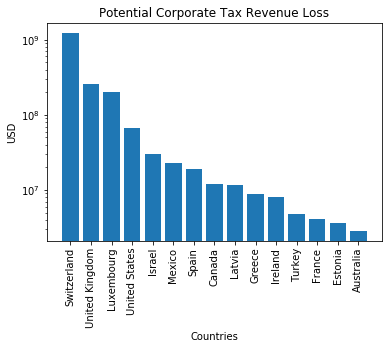

In [71]:
m3.sort_values(['Potential Tax Lost'], inplace=True, ascending=False)
plt.bar(m3.Location[:15], m3['Potential Tax Lost'][:15])
plt.xticks(rotation=90)
plt.ylabel('USD')
plt.xlabel('Countries')
plt.yscale('log')
plt.title('Potential Corporate Tax Revenue Loss')

As seen from the graph, aside from Switzerland, many of the countries are not losing that much corporate tax revenue when compared to their actual corporate tax revenue. This may be because usually only large businesses with high profits have the motivation to transfer their money overseas, as they pay a larger percentages in home corporate tax. Thus they would average a higher `Avg tax per business` and consequently increase overall `Potential corporate tax loss`.

### Time dependence between entities presence in Panama Papers and GINI coefficient

A preliminary analysis of the relation between the number of panama papers and GINI was performed with the same techniques of the ones done above. No interesting results were found and it was decided to analyse the GINI vs the number of Panama Papers time relation.

#### GINI coefficient: Global perspective 

One interesting fact that could be analysed is the time correlation between the number of Panama Papers during the years and the yearly development of other indicators such as GINI coefficient. 

To do so, the total database is considering for different purpose that will be later explained. Firstly, only the columns regarding the last $15$ years are considered and stored in ``df_GDP_w``. Then an average over these years is considered to obtain a single expression for each country and for mitigate the presence of missing value in the data. The column ``GDP_x`` is added with the mean and all the other columns are dropped.

In [72]:
cols=[0]+list(range(-17,-1))
df_GDP_w=df_GDP_tot_raw.iloc[:,cols].copy()
df_GDP_w['GDP_x'] = df_GDP_w.iloc[:,range(-15,0)].mean(axis=1,numeric_only=True)
df_GDP_w=df_GDP_w.drop(df_GDP_w.columns[1:17],axis=1)
#df_GDP_w

Now, different filter can be applied to this data frame that will influence the final data plotted later because of the presence of different joins between the latter dataset and two others. The example showed considers only countries with a GDP higher that a threshold now set to the unrealistic value of $200$, so basically considering all countries present in the data frame. 

In [73]:
df_GDP_w=df_GDP_w[df_GDP_w['GDP_x']>200]#*10e9]
#df_GDP_w=df_GDP_w[df_GDP_w['Country Name']=='Cyprus']
df_GDP_w.head()

,Country Name,GDP_x
0,Aruba,2.402359e+09
1,Afghanistan,1.292136e+10
2,Angola,7.248887e+10
3,Albania,1.044583e+10
4,Andorra,3.188988e+09


For counting the Panama Papers, the `` df_entity_raw`` is firstly joined with ``df_GDP_w`` to consider only countries previously filtered and then all the rows with $NaN$ are dropped. 

In [74]:
df_entity_S2 = df_entity_raw.copy()
df_entity_S2=df_entity_S2.merge(df_GDP_w, how='left',left_on='countries', right_on='Country Name')
df_entity_S2=df_entity_S2[pd.notnull(df_entity_S2['GDP_x'])]
#df_entity_S2

Through converting the year column into index and use it through different function, the count of the number of entities of the countries considered going offshore yearly is calculated.

In [75]:
df_entity_S2.incorporation_date = pd.to_datetime(df_entity_S2.incorporation_date)
df_entity_S2['Year'] = df_entity_S2.apply(lambda row: row['incorporation_date'].year, axis=1)
series_panamas = df_entity_S2.groupby(['Year'], axis=0)['Year'].count()
series_panamas.index = series_panamas.index.astype(int)

Here the other country feature dataset is introduced (in this case `` df_gini``). The dataset is cleaned from useless columns and the filtering join with the GDP dataset is performed. 

In [76]:
series_var = df_gini.copy()
series_var = series_var.drop(series_var.columns[1:4],axis=1).drop(series_var.columns[-1],axis=1)
series_var=series_var.merge(df_GDP_w, how='inner',left_on='Country Name', right_on='Country Name')

Now the latter data frame is average along the column direction, hence leaving all the years column. Different strategies were considered to make the latter average, as the purely arithmetic mean is not ideal. This is because different countries have very different weight in the world economy. One strategy was to use the GDP as weight of the country importance. This did not end up being a good solution as not all the values are available every year and so the absence of the value of a big country in one precise timestep would alter the result a lot. 

In [77]:
series_var[series_var.columns[1:57]]=series_var[series_var.columns[1:57]]#.divide(series_var['GDP_x'], axis='rows')
series_var=series_var[series_var.columns[1:57]]
series_var = series_var.mean(axis=0, skipna=True)
series_var.index = series_var.index.astype(int)

Now the 2 resulting series are plotted in one graph with the following code. Only ear after 1979 are considered as before there is no significant yearly number of Panama Papers. The results are standardized with min-max standardization to plot them on a single graph and easily compared their trend and correlation.

In [78]:
series_panamas_cut = series_panamas[series_panamas.index>=1979]
series_panamas_cut = (series_panamas_cut-series_panamas_cut.min())/(series_panamas_cut.max()-series_panamas_cut.min())
series_var_cut=series_var[series_var.index>=1979]
series_var_cut=(series_var_cut-series_var_cut.min())/(series_var_cut.max()-series_var_cut.min())
df_plot = pd.concat([series_var_cut, series_panamas_cut], axis=1)
df_plot.columns = [['Gini coefficient','Panama papers count']]

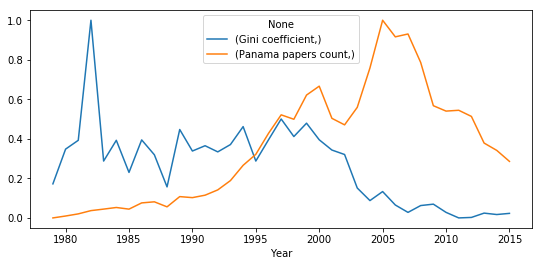

In [79]:
df_plot.plot(figsize=(9,4))

Text(0,0.5,'Panama papers count')

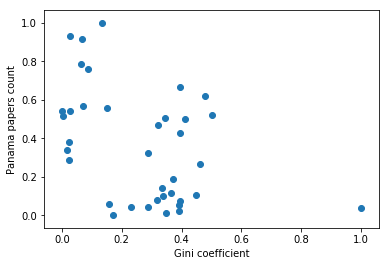

In [80]:
plt.scatter(df_plot['Gini coefficient'], df_plot['Panama papers count'])
plt.xlabel('Gini coefficient')
plt.ylabel('Panama papers count')

The resulting plot that can be seen here above. It can be seen that, on a world scale, there is no clear correlation between the develop of the GINI and the number of worldwide entities in the Panama Papers. To confirm the hypothesis that a higher number of panama paper is a sign of more inequality in the world, the two parameters would be positively correlated, so showing similar trend. All the countries in the world are very different from each other and their behaviour in the Papers can be influenced by a lot of other covariates. A machine learning algorithm could be a nice solution to find some relation using more features, but it would be very limited by the small amount of point available (the number of world countries).

In [81]:
def series_var_processing(df,weighting):
    series_var = df.copy()
    series_var = series_var.drop(series_var.columns[1:4],axis=1).drop(series_var.columns[-1],axis=1)
    series_var=series_var.merge(df_GDP_w, how='inner',left_on='Country Name', right_on='Country Name')
    #Here the weighting of GINI is performed 
    if weighting:
        series_var[series_var.columns[1:57]]=series_var[series_var.columns[1:57]].divide(series_var['GDP_x'], axis='rows')
    series_var=series_var[series_var.columns[1:57]]
    series_var = series_var.mean(axis=0, skipna=True)
    series_var.index = series_var.index.astype(int)
    series_panamas_cut = series_panamas[series_panamas.index>=1979]
    series_panamas_cut = (series_panamas_cut-series_panamas_cut.min())/(series_panamas_cut.max()-series_panamas_cut.min())
    series_var_cut=series_var[series_var.index>=1979]
    return (series_var_cut-series_var_cut.min())/(series_var_cut.max()-series_var_cut.min())

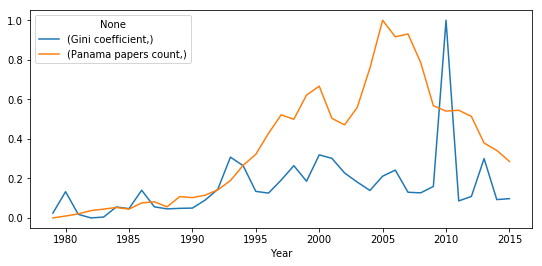

In [82]:
series_var_cut=series_var_processing(df_gini,True)
df_plot = pd.concat([series_var_cut, series_panamas_cut], axis=1)
df_plot.columns = [['Gini coefficient','Panama papers count']]
df_plot.plot(figsize=(9,4))

In the graph above the same procedure as descripted above is used but this time the GINI coefficient is weighted by dividing it by the GDP. The scatter plot is not showed no consequent time dependence could be seen in that. In this occasion the result does not seem to show any relation. The weighting of the GINI moderates its fluctuations, but missing data creates outliers. A pseudo correlation can be noticed in the first $15 - 17$ years of the plot.

#### GINI coefficient: G7 countries 

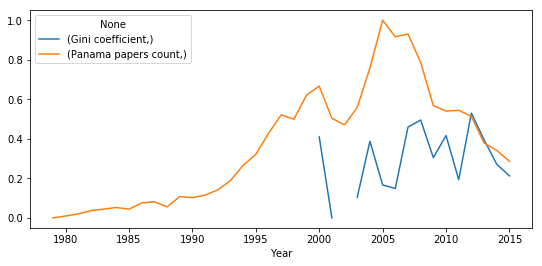

In [83]:
df_GDP_w=df_GDP_tot_raw.iloc[:,cols].copy()
df_GDP_w['GDP_x'] = df_GDP_w.iloc[:,range(-15,0)].mean(axis=1,numeric_only=True)
df_GDP_w=df_GDP_w.drop(df_GDP_w.columns[1:17],axis=1)
#Country filtering
df_GDP_w=df_GDP_w[df_GDP_w['GDP_x']>200*10e9]
df_entity_S2 = df_entity_raw.copy()
df_entity_S2=df_entity_S2.merge(df_GDP_w, how='left',left_on='countries', right_on='Country Name')
df_entity_S2=df_entity_S2[pd.notnull(df_entity_S2['GDP_x'])]
df_entity_S2.incorporation_date = pd.to_datetime(df_entity_S2.incorporation_date)
df_entity_S2['Year'] = df_entity_S2.apply(lambda row: row['incorporation_date'].year, axis=1)
series_panamas = df_entity_S2.groupby(['Year'], axis=0)['Year'].count()
series_panamas.index = series_panamas.index.astype(int)
series_var_cut=series_var_processing(df_gini,False)
df_plot = pd.concat([series_var_cut, series_panamas_cut], axis=1)
df_plot.columns = [['Gini coefficient','Panama papers count']]
df_plot.plot(figsize=(9,4))

As previously mentioned, the countries can be filtered by GDP using the GDP database which used with the correct join can act as a filter also for the others. The result, as in the previous case of the Tax rate, is not very meaningful. The data frame analysed has a lot of missing data, hence showing a continuous trend of it just in the last 10 years. Moreover, even in this small period, no observed correlation can be observed.

All in all the GINI coefficient has not shown to be dependent from the number of offshore entities.
It is probable that the increasing number of offshore entities does indeed strenghten income inequality, but this cannot be proven on a macroscopic scale with the help of data used in this exploration. 

# What about staying onshore?

The exploration above has provided numerous insights not only on the causes influencing entities to go offshore, but also on the consequences that such practises have on the home countries and could have on world income inequality in the long run, as the unknown leaker as mentioned. Some of the causes behind going offshore can be explained with data; in fact further researches are needed to obtain a greater quantity of data and use them to explore which are determinants of the number of offshore companies. In addition the phenomenon is also a sociological one and the story of each entity should be treated separately. All in all a stakeholder analysis should be performed to understand which are the individuals that, hidden behind the privacy curtains of the offshore jurisdictions, evade taxation disabling a proper redistribution of wealth. 